In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from tqdm import tqdm
import selfies as sf
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from rdkit.Chem import rdGeometry
from rdkit.Chem import rdDetermineBonds

def load_rings(fid):
    """Loads the informations about the rings from HDF5 file"""
    with h5py.File(feature_files[fid], "r") as f:
        rings_dset = f["rings"]
        ring_counts = f["nrings"][:]

        # Recover rings per molecule
        all_rings = []
        start = 0
        for count in ring_counts:
            rings = [rings_dset[i] for i in range(start, start + count)]
            all_rings.append(rings)
            start += count
            
        planar_fit_errors = f["errors"][:]
        triptlets_arr = f["plane_angles"][:]
        triptlets = [(int(i), int(j), float(val)) for i, j, val in zip(triptlets_arr["i"], triptlets_arr["j"], triptlets_arr["val"])]

        # Reconstruct plane angles per molecule
        ring_plane_angles = []
        count = 0
        for n_rings in ring_counts:
            n_pairs = n_rings * (n_rings - 1) // 2
            mol_angles = triplets[count:count + n_pairs]
            ring_plane_angles.append(mol_angles)
            count += n_pairs
        
    return ring_counts, all_rings, planar_fit_errors, ring_plane_angles

def load_isomer_dict(fid):
    """Loads a dictionary of molecule ids that have the same canonical SMILES id as key"""
    with h5py.File(molecule_files[fid], 'r') as f:
        return json.loads(f.attrs["isomers"])  # restore dict

def load_molecule_hdf5(fid, idx=42):
    """Load single molecule info from HDF5 file"""
    with h5py.File(molecule_files[fid], 'r') as f:
        # Get coordinates and reshape
        coords_flat = f['coords'][idx]
        coords = np.array(coords_flat.reshape(-1, 3))
        
        # Get atom types (decode bytes to string)
        atoms_str = f['atoms'][idx].decode('utf-8')
        atoms = atoms_str.split('|')

        # SMILES and SELFIES
        smiles = f['smiles'][idx].decode('utf-8')   
        selfies = f['selfies'][idx].decode('utf-8')

    with h5py.File(feature_files[fid], "r") as f:
        dimension = f["dimensions"][idx].decode("utf-8")
        point_group = f["point_groups"][idx].decode("utf-8")
        n_symmetry_planes = f["symmetry_planes"][idx]
        chirality = f["chiralities"][idx].astype(bool)
        ring_count = f["nrings"][idx]
        
    return {"coords": coords, "atoms": atoms, "smiles": smiles, "selfies": selfies,
            "dimension": dimension, "point_group": point_group, "n_symmetry_planes": n_symmetry_planes, "chirality": chirality, "nrings": ring_count}

def load_parameter_of_all_molecules(h5_files, data="atoms"):
    """Iterate over multiple .h5 molecule files and yield one molecule info at a time"""
    if data == "coords":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["coords"])):
                    coords_flat = f["coords"][idx]
                    yield coords_flat.reshape(-1, 3)
    elif data == "atoms":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["atoms"])):
                    atom_types_str = f["atoms"][idx].decode("utf-8")
                    yield atom_types_str.split("|")
    elif data == "smiles":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["smiles"])):
                    yield f["smiles"][idx].decode("utf-8")
    elif data == "selfies":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["selfies"])):
                    yield f["selfies"][idx].decode("utf-8")
    elif data == "dimensions":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["dimensions"])):
                    yield f["dimensions"][idx].decode("utf-8")
    elif data == "point_groups":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["point_groups"])):
                    yield f["point_groups"][idx].decode("utf-8")
    elif data == "symmetry_planes":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["symmetry_planes"])):
                    yield f["symmetry_planes"][idx].astype(int)
    elif data == "chiralities":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["chiralities"])):
                    yield f["chiralities"][idx].astype(bool)
    elif data == "nrings":
        for file_path in h5_files:
            with h5py.File(file_path, "r") as f:
                for idx in range(len(f["nrings"])):
                    yield f["nrings"][idx].astype(int)

def plot_distribution(data, save_path=None, xlabel=None, title=None, log_scale=True, fontsize=12, bins=50, figsize=(5, 2.5)):
    """Plot distribution of categorical or numerical data"""
    plt.figure(figsize=figsize)

    if isinstance(data[0], str):
        try:
            # categorical bar chart
            counts = Counter(data)
            sorted_counts = counts.most_common()  # returns list of (key, count) tuples
            labels, values = zip(*sorted_counts)
            plt.bar(labels, values)
            plt.xticks(rotation=90, fontsize=fontsize)
        except:
            print("The data in the list is non homogenous")
    elif isinstance(data[0], int):
        try:
            # numeric histogram
            plt.hist(data, bins=bins)
        except:
            print("the data in the list is non homogenous")
    else:
        raise ValueError("Data must be either list of strings or list of integers.")

    # Axis formatting
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fontsize + 2)
    plt.ylabel("Count", fontsize=fontsize + 2)
    if log_scale:
        plt.yscale("log")
    plt.margins(x=0.01)
    if title is not None:
        plt.title(title, fontsize=fontsize + 2)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

def visualize_molecule(fid=0, idx=42, width=300, height=300, text=True, rings=None, normals=None, planes=False):
    """Outputs an interactive 3D model of a molecule"""
    coords, atoms, smiles, selfies = load_molecule_hdf5(fid, idx)

    if text:
        print(f"Molecule is comprised of {len(atoms)} atoms:\n{atoms}")
        print(f"The coordinates are:\n{coords}")
        
    # Create editable molecule and add atoms
    molecule = Chem.RWMol()
    for atom in atoms:
        molecule.AddAtom(Chem.Atom(atom))

    # Add 3D conformer
    conf = Chem.Conformer(len(atoms))
    for i, (x, y, z) in enumerate(coords):
        conf.SetAtomPosition(i, rdGeometry.Point3D(float(x), float(y), float(z)))
    molecule.AddConformer(conf)

    # Figure out bonds
    try: rdDetermineBonds.DetermineBonds(molecule)
    except Exception as e: print(f"Bond generation failed: {e}")
    
    # Generate MOL block using RDKit’s built-in method to ensure proper 3D representation
    mol_block = Chem.MolToMolBlock(molecule)
    
    # Visualize interactively
    view = py3Dmol.view(width=width, height=height)
    view.addModel(mol_block, 'mol')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'radius': 0.3}})

    if planes:
        for ring, normal in zip(rings, normals):
            ring_coords = coords[ring]
            centroid = ring_coords.mean(axis=0)
            start = centroid
            end = centroid + normal * 1.0  # scale arrow for visibility
        
            arrow = {
                'start': {'x': float(start[0]), 'y': float(start[1]), 'z': float(start[2])},
                'end':   {'x': float(end[0]),   'y': float(end[1]),   'z': float(end[2])},
                'color': 'red',
                'radius': 0.05
            }
            view.addArrow(arrow)
    
    view.zoomTo()
    view.show()

def combine_plots(images, x_p=1, y_p=1, figsize=(12, 24), title="Combined plots", fontsize=12, saveto="combined_plots.jpg"):
    """Combines existing images into one plot"""
    fig, axs = plt.subplots(x_p, y_p, figsize=figsize)
    
    axs = axs.flatten()
    
    for i, (ax, image) in enumerate(zip(axs, images)):
        img = mpimg.imread(image)   # Load the saved plot
        ax.imshow(img)
        ax.axis("off")  # Hide axis ticks
    
    # Add a main title for the whole figure
    fig.suptitle(title, fontsize=fontsize)
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle
    plt.savefig(saveto, bbox_inches="tight")
    plt.show()

def compare_distributions():
    diff_indices = [i for i, (x,y) in enumerate(zip(sofi_pgs,sofi_static_pgs)) if x != y]
    counts1 = Counter(sofi_pgs)
    counts2 = Counter(pymsym_pgs)
    
    labels = sorted(set(counts1.keys()) | set(counts2.keys()))
    vals1 = [counts1.get(l, 0) for l in labels]
    vals2 = [counts2.get(l, 0) for l in labels]
    
    x = np.arange(len(labels))
    width = 0.4
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, vals1, width, label=f'SOFI, sym_thr = {sym_thr}')
    ax.bar(x + width/2, vals2, width, label='pymsym')
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_yscale("log")
    ax.set_ylabel("Counts", fontsize=14)
    ax.set_xlabel("Point Groups", fontsize=14)
    ax.set_title(f"Comparison of computed point group distribution of {n_samples} molecules", fontsize=16)
    ax.legend(fontsize=14)
    
    # ---------- Small Pie Chart ----------
    numer = positional_overlap
    denom = len(sofi_pgs)
    sizes = [numer, denom - numer]
    colors = ["green", "red"]
    
    # Position: (x0, y0, width, height) in axes fraction (0 to 1)
    # x0, y0 = bottom-left corner of the inset
    ax_inset = inset_axes(ax, width=1, height=1,  # fraction of parent axes
                          bbox_to_anchor=(0.8, 0.65, 0.15, 0.15),  # x0, y0, width, height
                          bbox_transform=ax.transAxes)
    
    ax_inset.pie(
        sizes,
        colors=colors,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor="white")
    )
    ax_inset.set_aspect("equal")
    
    # Add label under the pie
    ax_inset.text(0.5, -0.2, f" {numer/denom:.1%} agreement", ha='center', va='center', transform=ax_inset.transAxes, fontsize=14)
    
    plt.savefig(f"pgs_comparison_{sym_thr}.png", bbox_inches="tight")
    plt.show()

def find_indices(lst, target, inside=True):
    """Finds indices of specific items in a list"""
    if inside:
        return [i for i, val in enumerate(lst) if target in val]
    else:
        return [i for i, val in enumerate(lst) if target == val]

In [2]:
molecule_files = ["mol3d_data/mol3d_mil1.h5",
                  "mol3d_data/mol3d_mil2.h5",
                  "mol3d_data/mol3d_mil3.h5",
                  "mol3d_data/mol3d_mil4.h5"]
feature_files = ["mol3d_data/mol3d_feat_mil1.h5",
                "mol3d_data/mol3d_feat_mil2.h5",
                "mol3d_data/mol3d_feat_mil3.h5",
                "mol3d_data/mol3d_feat_mil4.h5",]
fid = 0

In [14]:
molecule = load_molecule_hdf5(fid)
print(molecule)

{'coords': array([[ 0.7266, -0.0447, -0.0413],
       [ 0.1404, -0.6432, -1.3245],
       [-1.0468, -0.8979, -1.4122],
       [ 1.017 , -0.8491, -2.2972],
       [ 0.3713, -0.9147,  1.1829],
       [ 1.2331, -1.1713,  1.9948],
       [-0.8935, -1.3019,  1.2849],
       [ 2.1213,  0.0962, -0.1485],
       [ 0.2426,  0.9341,  0.1009],
       [ 1.896 , -0.593 , -1.9344],
       [-1.3508, -1.1242,  0.4253],
       [ 2.4855, -0.3245,  0.6604]], dtype=float32), 'atoms': ['C', 'C', 'O', 'O', 'C', 'O', 'O', 'O', 'H', 'H', 'H', 'H'], 'smiles': 'O=C(O)C(O)C(=O)O', 'selfies': '[O][=C][Branch1][C][O][C][Branch1][C][O][C][=Branch1][C][=O][O]', 'dimension': '3D', 'point_group': 'C1', 'n_symmetry_planes': np.int32(0), 'chirality': np.True_, 'nrings': np.int32(0)}


In [9]:
visualize_molecule(fid, 42)

Molecule is comprised of 12 atoms:
['C', 'C', 'O', 'O', 'C', 'O', 'O', 'O', 'H', 'H', 'H', 'H']
The coordinates are:
[[ 0.7266 -0.0447 -0.0413]
 [ 0.1404 -0.6432 -1.3245]
 [-1.0468 -0.8979 -1.4122]
 [ 1.017  -0.8491 -2.2972]
 [ 0.3713 -0.9147  1.1829]
 [ 1.2331 -1.1713  1.9948]
 [-0.8935 -1.3019  1.2849]
 [ 2.1213  0.0962 -0.1485]
 [ 0.2426  0.9341  0.1009]
 [ 1.896  -0.593  -1.9344]
 [-1.3508 -1.1242  0.4253]
 [ 2.4855 -0.3245  0.6604]]
Its SMILES id:
[H]OC(=O)C([H])(O[H])C(=O)O[H]
Its SELFIES id:
[H][O][C][=Branch1][C][=O][C][Branch1][C][H][Branch1][Ring1][O][H][C][=Branch1][C][=O][O][H]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
all_smiles = load_parameter_of_all_molecules(molecule_files[:1], "smiles")
smiles_list = []
for smiles in tqdm(all_smiles, desc="Processing molecules:", unit="mol"):
    smiles_list.append(smiles)

Processing molecules:: 998986mol [04:13, 3936.39mol/s]


In [28]:
ind = find_indices(smiles_list, "TB", inside=True)
for i in ind:
    print(smiles_list[i])

F[P@TB2](F)(F)(F)F
F[S@TB20](F)(F)F
Cl[P@TB17](Cl)(Cl)(Cl)Cl
C[S@TB15](O)(O)O
F[P@TB14](F)(F)(F)C1=CC=CC=C1
CO[P@TB13]1(OC)(OC)OC(C)=C(C)O1
C[P@TB2](Cl)(Cl)(Cl)Cl
CCN(CC)[S@TB20](F)(F)F
CO[P@TB19](O)(O)(OC)OC
CN(C)[P@TB2](F)(F)(F)N(C)C
CN(C)[P@TB19](F)(F)(F)F
CN1C(=O)N(C)[P@TB3]1(Cl)(Cl)Cl
CN1[P@TB8](F)(F)(F)N(C)[P@TB6]1(F)(F)F
CN(C)[P@TB19](F)(F)(N(C)C)N(C)C
CN1C(=O)N(C2=CC=CC=C2)[P@TB2]1(C)(F)F
CN1C(=O)N(C)[P@TB2]1(C)(F)F
CC[P@TB13]1(F)(F)N(C)C(=O)N1C
CN1C(=O)N(C)[P@TB14]1(F)(F)F
CN1C(=O)N(C)[P@TB6]1(F)(F)C1=CC=CC=C1
CN1C(=O)N(C)[P@TB2]1(C)(C)F
FP(F)N[P@TB19](F)(F)(F)F
FSS[S@TB15](F)(F)F
CO[S@TB20](O)(O)O
O=C1O[P@TB8](Cl)(Cl)(Cl)OC2=C1C=CC=C2
C[C@]1(Cl)O[P@TB17](Cl)(Cl)(Cl)OC2=CC=CC=C21
Cl[C@@H]1O[P@TB8](Cl)(Cl)(Cl)OC2=C1C=CC=C2
CC1(C)CO[P@TB6]23(OCC[C@H](CO2)O3)O1
CC1(C)O[S@TB2]2(C3=CC=CC=C3)OC(=O)C3=CC=CC1=C32
CC(C)(C)C1=CC2=C3C(=C1)C(C)(C)O[S@TB1]3(C)OC2(C)C
CC1(C)O[P@TB17]2(O)(OC(C)(C)C3=CC=CC=C32)C2=CC=CC=C21
O=C1CC[S@TB20]2(CCC(=O)O2)O1
C[P@TB17]12(OC(=O)C3=CC=CC=C31)OC(=O)C1=C

In [3]:
all_smiles = load_parameter_of_all_molecules(molecule_files, "smiles")
len_smiles = []
for smiles in tqdm(all_smiles, desc="Processing molecules:", unit="mol"):
    len_smiles.append(len(smiles))

Processing molecules:: 3897897mol [12:20, 5267.38mol/s]


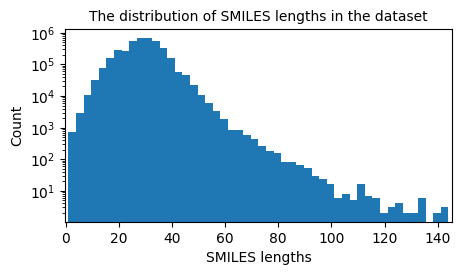

In [51]:
plot_distribution(len_smiles,
                  "smiles_length_distribution.png",
                  "SMILES lengths",
                  "The distribution of SMILES lengths in the dataset", fontsize=8)

In [5]:
all_atoms = load_parameter_of_all_molecules(molecule_files, "atoms")
len_atoms = []
for atoms in tqdm(all_atoms, desc="Processing molecules:", unit="mol"):
    len_atoms.append(len(atoms))

Processing molecules:: 3897897mol [12:23, 5246.12mol/s]


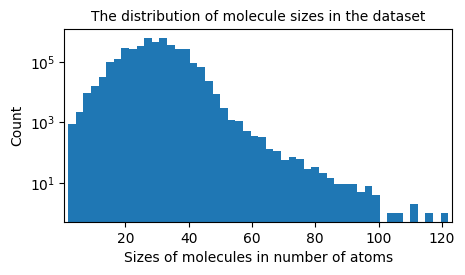

In [55]:
plot_distribution(len_atoms,
                  "molecule_size_distribution.png",
                  "Sizes of molecules in number of atoms",
                  "The distribution of molecule sizes in the dataset", fontsize=8)

In [56]:
all_selfies = load_parameter_of_all_molecules(molecule_files, "selfies")
len_selfies = []
for selfies in tqdm(all_selfies, desc="Processing molecules:", unit="mol"):
    len_selfies.append(len(selfies))

Processing molecules:: 3897897mol [12:12, 5321.69mol/s]


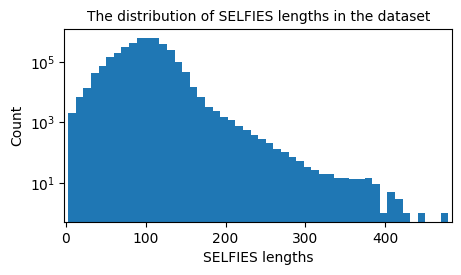

In [57]:
plot_distribution(len_selfies,
                  "selfies_length_distribution.png",
                  "SELFIES lengths",
                  "The distribution of SELFIES lengths in the dataset", fontsize=8)

In [9]:
all_rings = load_parameter_of_all_molecules(feature_files, "nrings")
nrings = []
for nring in tqdm(all_rings, desc="Processing molecules:", unit="mol"):
    nrings.append(nring)

Processing molecules:: 3897897mol [08:03, 8068.52mol/s]


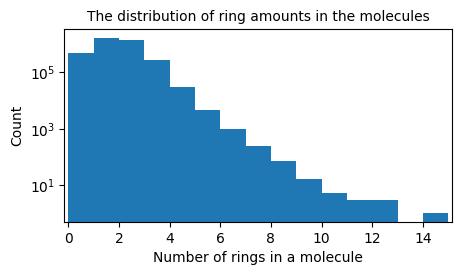

In [53]:
plot_distribution(list(map(int, nrings)),
                  "molecule_ring_amount_distribution.png",
                  "Number of rings in a molecule",
                  "The distribution of ring amounts in the molecules", fontsize=8, bins=15)

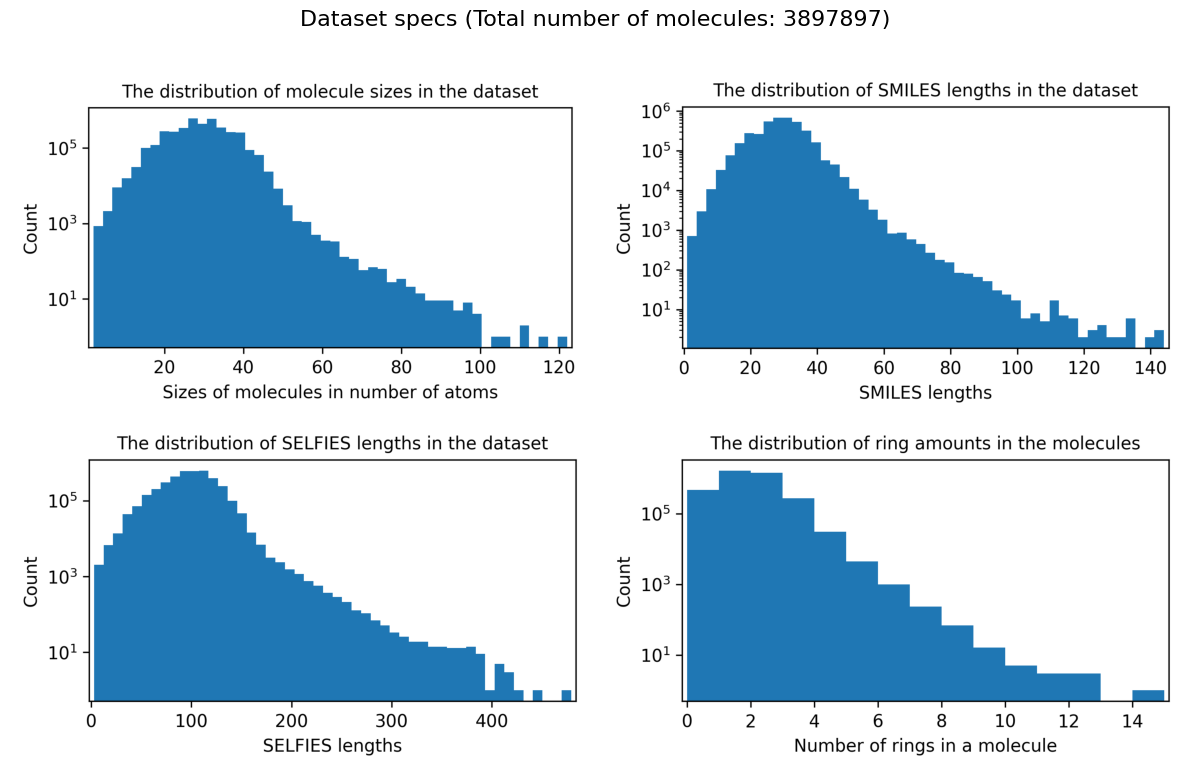

In [58]:
combine_plots(["molecule_size_distribution.png",
               "smiles_length_distribution.png",
               "selfies_length_distribution.png",
               "molecule_ring_amount_distribution.png"],
               x_p=2, y_p=2, figsize=(12, 8), fontsize=16,
               title=f"Dataset specs (Total number of molecules: {len(len_atoms)})",
               saveto="dataset_info.jpg")

In [30]:
all_atoms = load_parameter_of_all_molecules(molecule_files, "atoms")
atom_types = []
for atoms in tqdm(all_atoms, desc="Processing molecules:", unit="mol"):
    atom_types.extend(atoms)

Processing molecules:: 3897897mol [13:11, 4922.01mol/s]


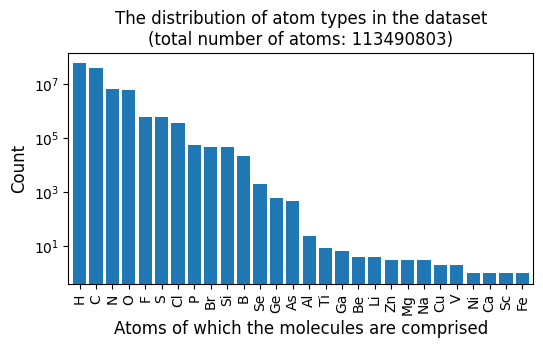

In [62]:
plot_distribution(atom_types,
                  "molecule_atom_type_distribution.png",
                  "Atoms of which the molecules are comprised",
                  f"The distribution of atom types in the dataset\n(total number of atoms: {len(atom_types)})",
                  figsize=(6, 3), fontsize=10)

In [38]:
all_selfies = load_parameter_of_all_molecules(molecule_files, "selfies")
selfies_symbols = []
for selfies in tqdm(all_selfies, desc="Processing molecules:", unit="mol"):
    selfies_symbols.extend(sf.split_selfies(selfies))

Processing molecules:: 3897897mol [14:13, 4568.82mol/s]


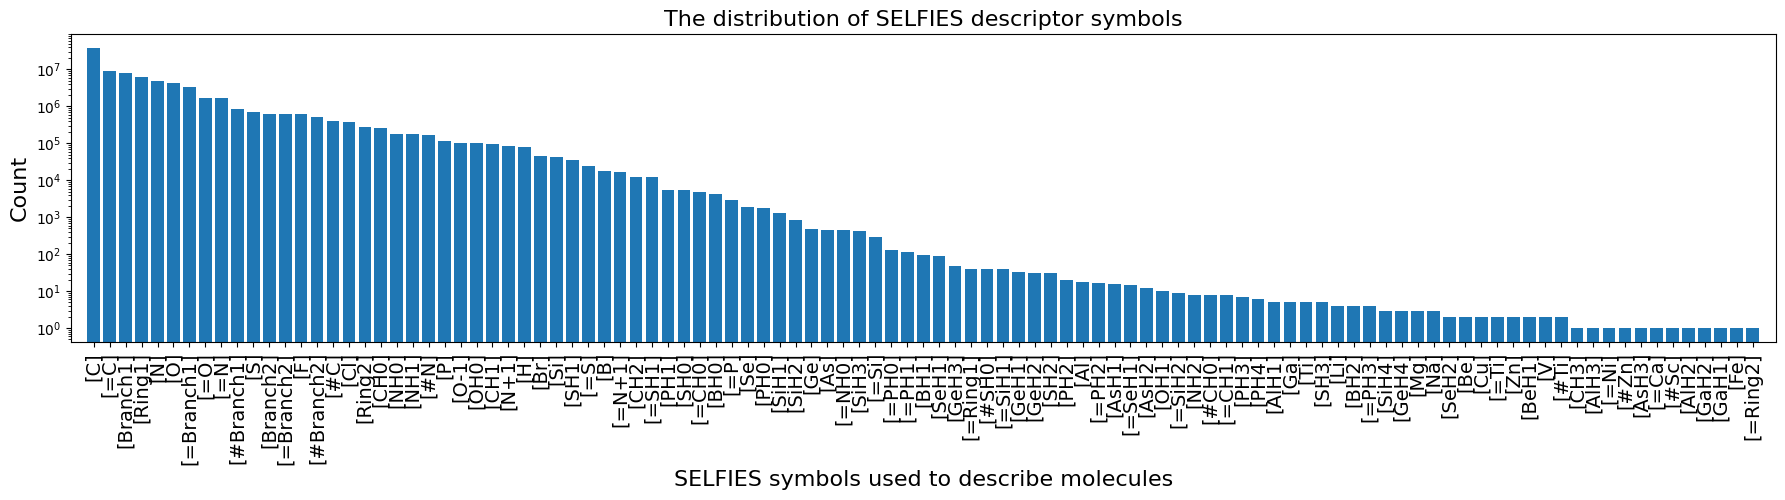

In [50]:
plot_distribution(selfies_symbols,
                  "selfies_symbol_type_distribution.png",
                  "SELFIES symbols used to describe molecules",
                  f"The distribution of SELFIES descriptor symbols",
                 figsize=(22, 4), fontsize=14)

In [13]:
all_selfies = load_parameter_of_all_molecules(files[:1], "selfies")
len_selfies = []
for selfies in tqdm(all_selfies, desc="Processing molecules:", unit="mol"):
    len_selfies.append(len(selfies))

Processing molecules:: 998976mol [03:58, 4196.25mol/s]


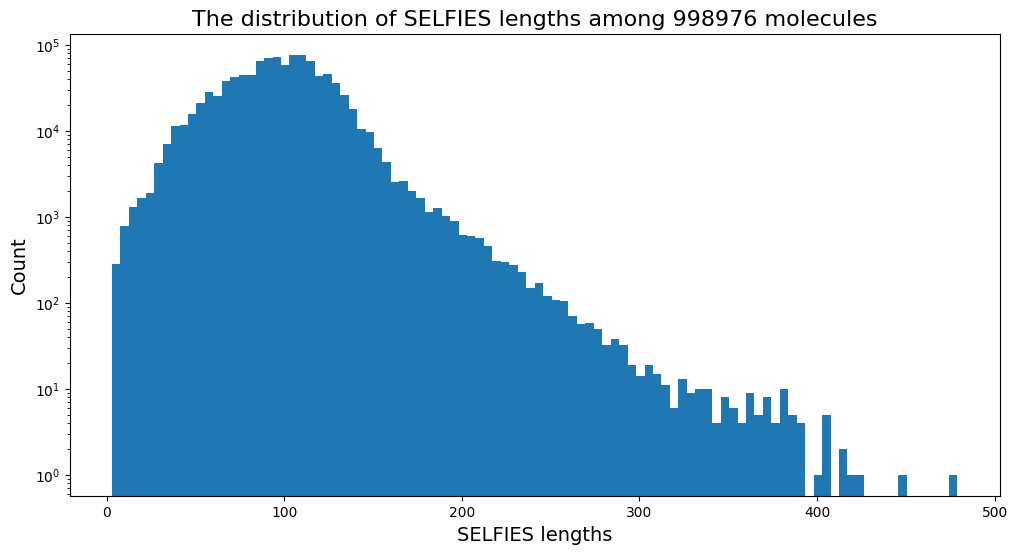

In [14]:
plot_distribution(len_selfies,
                  "selfies_length_distribution.png",
                  "SELFIES lengths",
                  f"The distribution of SELFIES lengths among {len(len_selfies)} molecules",
                 bins=100)

In [3]:
all_point_groups = load_parameter_of_all_molecules(feature_files, "point_groups")
point_groups = []
for pg in tqdm(all_point_groups, desc="Processing molecules:", unit="mol"):
    point_groups.append(pg)

Processing molecules:: 3897897mol [11:47, 5507.46mol/s]


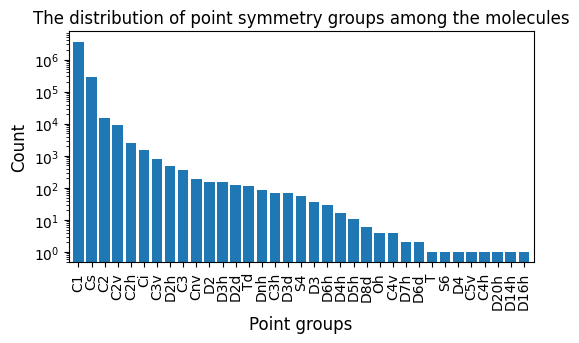

In [5]:
plot_distribution(point_groups,
                  "molecule_point_group_distribution.png",
                  "Point groups",
                  "The distribution of point symmetry groups among the molecules",
                  figsize=(6, 3), fontsize=10)